# Abstract

A Kaggle client that provides health insurance is interested in providing vehicle insurance to the same customers. To this end, the client wants a model to predict whether a health insurance customer would be interested such an offer. In this report, two classification models, Logistic Regression and Random Forest Sampling, are used to predict the response of a customer. 

# Introduction

The primary purpose of this project is to practice training models in general. This project was previously done using only data exploration without providing a model. However, this dataset is a very good example of real-world data that models can train on. I also practice using k-fold cross validation and try to balance the response data.

# Research Question
* Is Logistic Regression or Random Forest Sampling more effective and predicting customer response? 
* In what situation is one more reasonable than the other?

## Imported libraries
* _pandas_ and _numpy_ to manipulate data
* _sklearn_ for training models.
* _matplotlib_ to draw charts
* _seaborn_ to draw the confusion matrix.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Exploratory data analysis
As the data was downloaded directly from kaggle in the form of a csv, read_csv() will allow us to load and view the data set. There is a train and test set in the data provided for machine learning purposes, but for this assignment I will treat the _train.csv_ as the complete set since _test.csv_ has no response labels. The column _Response_ is what we are trying to predict. A 1 means that customer is interested in purchasing insurance, and a 0 means otherwise.

In [2]:
insurance_data = pd.read_csv("../data/train.csv")
insurance_data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


## Data validation and initial observations
First, I check for any null or N/A values, and I find none.

In [3]:
na_mask = insurance_data.isna()
na_mask.sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Here, I replace "Yes"/"No" columns with 0/1. While this makes for a messy chart, the training models will only accept numerical data. Since _Vehicle_Age_ is ordinal data, using 0-2 should be acceptable. Using 0/1 for _Vehicle_Damage_ and _Gender_ feels strange since they are not ordinal, but it feels better than using one hot encoding on binary data.

In [4]:
insurance_data["Vehicle_Age"].replace("< 1 Year", 0, inplace = True)
insurance_data["Vehicle_Age"].replace("1-2 Year", 1, inplace = True)
insurance_data["Vehicle_Age"].replace("> 2 Years", 2, inplace = True)

insurance_data["Vehicle_Damage"].replace("No", 0, inplace = True)
insurance_data["Vehicle_Damage"].replace("Yes", 1, inplace = True)

insurance_data["Gender"].replace("Male", 0, inplace = True)
insurance_data["Gender"].replace("Female", 1, inplace = True)

### Brief data observations
* The response distribution indicates relatively few people in the train set were actually interested in automobile insurance. This means the data needs to be balanced on response or the model will be biased towards predicting a negative response.
* The annual premium histogram looks very odd. There are most likely outliers.
* More than 99% of people in this set have a driver's license (then again, why would you need automobile insurance if you shouldn't be driving?)
* Vintage is uniformly distributed from about 10 to 300 days.
* Policy_Sales Channel and Region Code don't have very clear distributions.

While outliers appear in fetures such as _Annual_Premium_, I will not remove them since they should not negatively affect the models.

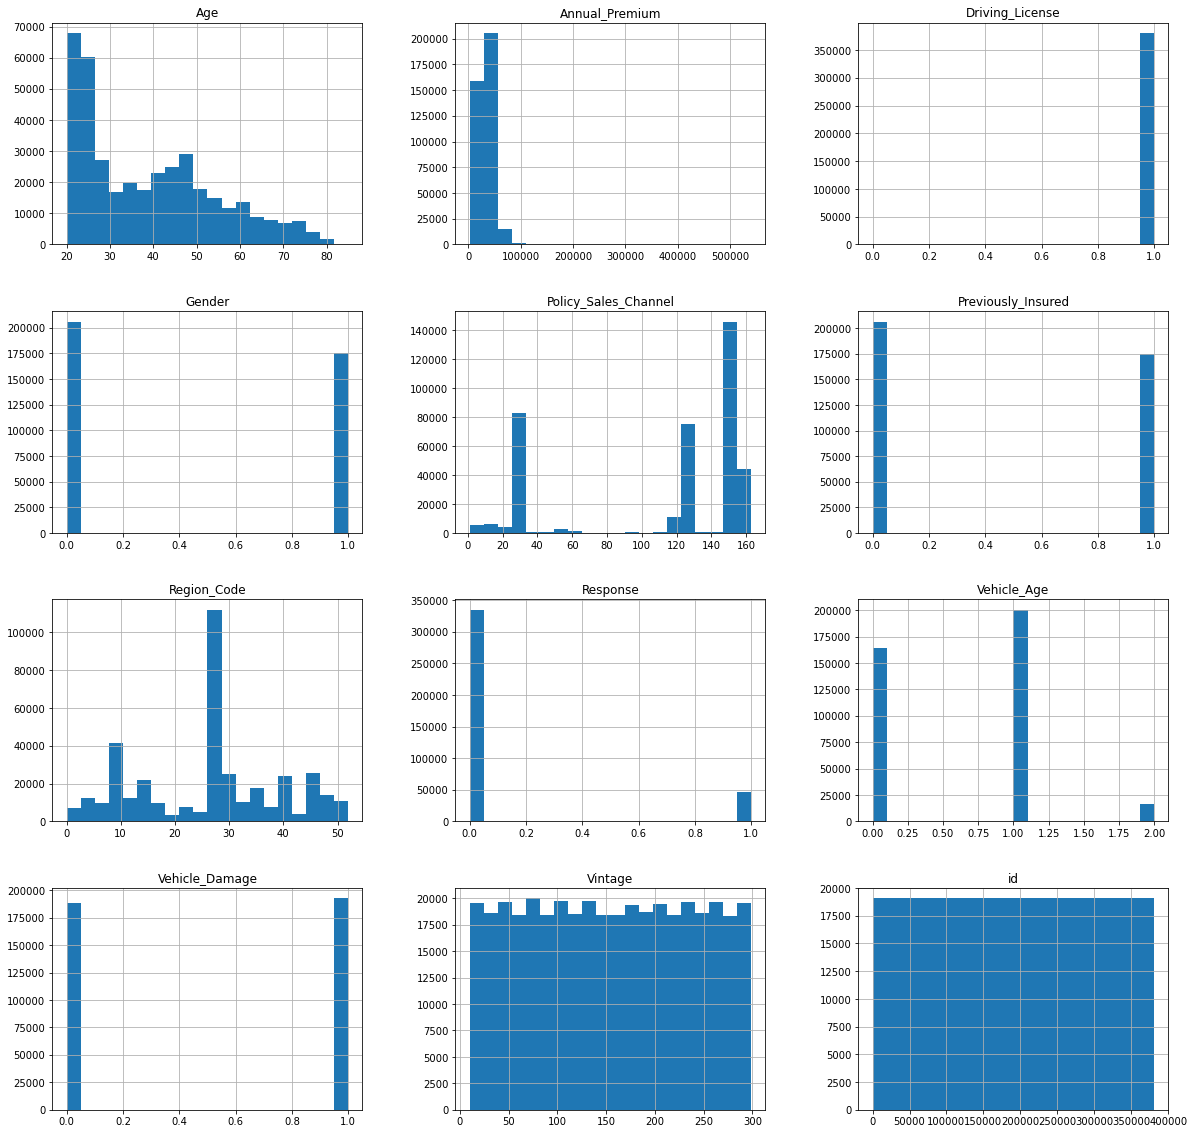

In [5]:
fig = insurance_data.hist(bins = 20, figsize = (20,20))

## Data modifications

Here, I drop the _id_ field since the id number should be independent of the response.

In [6]:
insurance_data = insurance_data.drop('id', axis = 1)

Since there are almost 7 times as many negative responses as there are positive responses, I opt for undersampling negative responses so that there are an equal amount of positive and negative responses in the data set. This should balance the classes so that the models are not biased towards negative responses. Fortunately, there are still about 100,000 samples to train with.

In [7]:
# Group all data by response and resample so that the # of positive responses (1) = the # of negative responses (0)
groups = insurance_data.groupby('Response')
balanced_insurance_data = groups.apply(lambda x: x.sample(groups.size().min()).reset_index(drop=True))
balanced_insurance_data['Response'].value_counts()

1    46710
0    46710
Name: Response, dtype: int64

## Training classification models

I try two different types of models here:
* Logistic Regression
* Random Forest Sampling

Logistic Regression is a relatively simple model, and I also wanted to try Random Forest Sampling out of curiosity.

### Cross-Validation

I use a stratified 5-fold approach. This way, I have more models to work with and I still have balanced data.

In [8]:
from sklearn.model_selection import StratifiedKFold

X = balanced_insurance_data.drop("Response", axis = 1)
y = balanced_insurance_data["Response"]
skf = StratifiedKFold(n_splits = 5)

### Training

I train each model type with each split in the 5-fold, getting 10 models and an accuracy score for each.

(This step took my computer about 5 minutes to complete, runtime may vary between machines)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logreg_models = [None] * 5
logreg_scores = [None] * 5

rfc_models = [None] * 5
rfc_scores = [None] * 5

i = 0
for train_i, test_i in skf.split(X, y):
    
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    logreg_models[i] = LogisticRegression()
    rfc_models[i] = RandomForestClassifier()

    logreg_models[i].fit(X_train_std, y_train)
    rfc_models[i].fit(X_train_std, y_train)
    
    logreg_scores[i] = logreg_models[i].score(X_test_std,y_test)
    rfc_scores[i] = rfc_models[i].score(X_test_std,y_test)
    
    print("Iteration:", i)
    print("   ", "Log Regression Score:", logreg_scores[i])
    print("   ", "Random Forest Score:", rfc_scores[i])
    
    i += 1

Iteration: 0
    Log Regression Score: 0.7833975594091201
    Random Forest Score: 0.7854849068721901
Iteration: 1
    Log Regression Score: 0.7834510811389425
    Random Forest Score: 0.7838257332476986
Iteration: 2
    Log Regression Score: 0.7839862984371655
    Random Forest Score: 0.7834510811389425
Iteration: 3
    Log Regression Score: 0.7805609077285378
    Random Forest Score: 0.7824876900021409
Iteration: 4
    Log Regression Score: 0.7861806893598801
    Random Forest Score: 0.783022907300364


It's hard to say that one model is more accurate than the other. The accuracies are all within 1% of each other. However, it is worth noting that Random Forest taking much more computing time.

In [16]:
from sklearn.model_selection import train_test_split

#Make new train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Predictions and errors

I'm surprised with the Logistic Regression results, primarily because there are far more false negatives compared to Random Forest. If the insurance company wants to target people who are likely to want insurance, it would generally be better to target too many people than too few. This means false positives are a bit more tolerable than false negatives. I would still use Random Forest for overall accuracy between both types of errors.

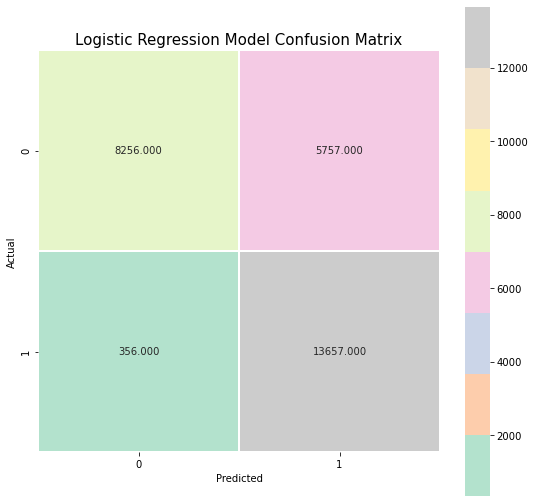

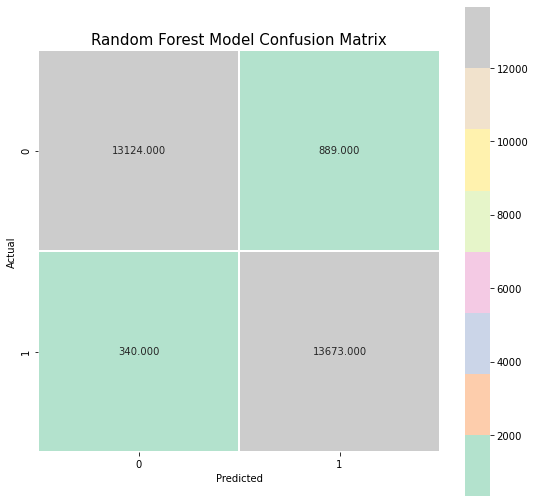

In [20]:
from sklearn import metrics

# Select model with highest accuracy
best_rfc_model = rfc_models[rfc_scores.index(max(rfc_scores))]
best_logreg_model = logreg_models[logreg_scores.index(max(logreg_scores))]

# Make predictions on test set
rfc_predictions = best_rfc_model.predict(X_test_std)
logreg_predictions = best_logreg_model.predict(X_test_std)
rfc_cm = metrics.confusion_matrix(y_test, rfc_predictions)
logreg_cm = metrics.confusion_matrix(y_test, logreg_predictions)

# Plot confusion matrices
plt.figure(figsize=(9,9))
sns.heatmap(logreg_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel2');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Logistic Regression Model Confusion Matrix'
plt.title(all_sample_title, size = 15);
plt.show()

plt.figure(figsize=(9,9))
sns.heatmap(rfc_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel2');
plt.ylabel('Actual');
plt.xlabel('Predicted');
all_sample_title = 'Random Forest Model Confusion Matrix'
plt.title(all_sample_title, size = 15);
plt.show()

## Results and Discussion

It seems that both models very closely mimmick the actual results, which is to be expected with high accuracy. However, the model does seem to predict slightly more positive responses than there actually are, as seen in the line charts.

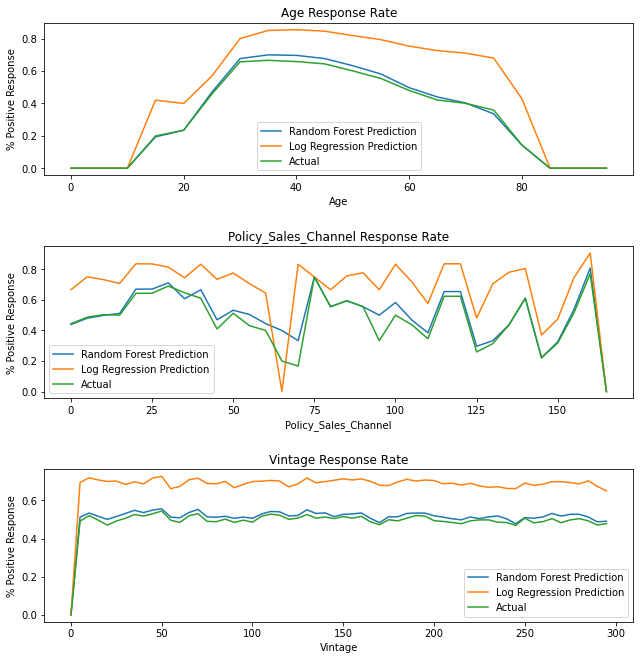

In [27]:
# Draws a line plotting response_rate with a column of the user's choice.
def line_bins_response_rate(range_arr, bin_size, column, X, y, ax, label):
    x_axis = range_arr
    y_axis = [None] * len(x_axis)
    for i, var in enumerate(x_axis):
        responses, counts = np.unique(y[(var < X[column]) & (X[column] < var + 10)], return_counts = True)
        try:
            y_axis[i] = counts[1] / (counts[0] + counts[1])
        except:
            y_axis[i] = 0

    ax.plot(x_axis, y_axis, label = label)
    #ax.fill_between(x_axis, y_axis)
    ax.set_title(column + " Response Rate")
    ax.set_xlabel(column)
    ax.set_ylabel("% Positive Response")
    ax.legend()

fig, ax = plt.subplots(3, figsize = (10, 10))
fig.tight_layout(pad=5.0)

line_bins_response_rate(range(0, 100, 5), 5, 'Age', X_test, rfc_predictions, ax[0], 'Random Forest Prediction')
line_bins_response_rate(range(0, 100, 5), 5, 'Age', X_test, logreg_predictions, ax[0], 'Log Regression Prediction')
line_bins_response_rate(range(0, 100, 5), 5, 'Age', X_test, y_test, ax[0], 'Actual')
line_bins_response_rate(range(0, 170, 5), 5, 'Policy_Sales_Channel', X_test, rfc_predictions, ax[1], 'Random Forest Prediction')
line_bins_response_rate(range(0, 170, 5), 5, 'Policy_Sales_Channel', X_test, logreg_predictions, ax[1], 'Log Regression Prediction')
line_bins_response_rate(range(0, 170, 5), 5, 'Policy_Sales_Channel', X_test, y_test, ax[1], 'Actual')
line_bins_response_rate(range(0, 300, 5), 5, 'Vintage', X_test, rfc_predictions, ax[2], 'Random Forest Prediction')
line_bins_response_rate(range(0, 300, 5), 5, 'Vintage', X_test, logreg_predictions, ax[2], 'Log Regression Prediction')
line_bins_response_rate(range(0, 300, 5), 5, 'Vintage', X_test, y_test, ax[2], 'Actual')

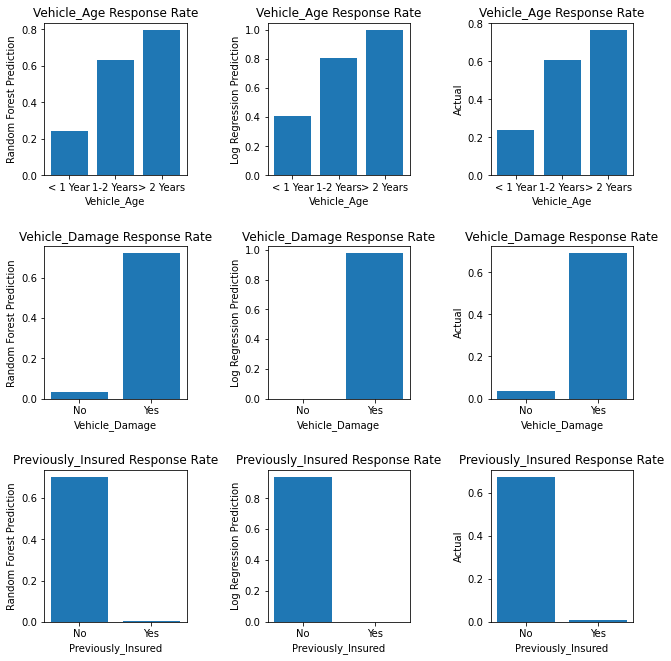

In [31]:
# Draws a bar chart plotting response_rate with a column of the user's choice.
def bar_response_rate(bars, column, X, y, ax, label):
    
    x_axis = range(len(bars))
    y_axis = [None] * len(bars)
    
    for i, x in enumerate(x_axis):
        responses, counts = np.unique(y[X[column] == x], return_counts = True)
        try:
            y_axis[i] = counts[1] / (counts[0] + counts[1])
        except:
            y_axis[i] = 0
            
    ax.bar(bars, y_axis, label = label)
    ax.set_title(column + " Response Rate")
    ax.set_xlabel(column)
    ax.set_ylabel(label)

fig, ax = plt.subplots(3, 3, figsize = (10, 10))
fig.tight_layout(pad=5.0)
    
bar_response_rate(["< 1 Year", "1-2 Years", "> 2 Years"], "Vehicle_Age", X_test, rfc_predictions, ax[0,0], 'Random Forest Prediction')
bar_response_rate(["< 1 Year", "1-2 Years", "> 2 Years"], "Vehicle_Age", X_test, logreg_predictions, ax[0,1], 'Log Regression Prediction')
bar_response_rate(["< 1 Year", "1-2 Years", "> 2 Years"], "Vehicle_Age", X_test, y_test, ax[0][2], 'Actual')
bar_response_rate(["No", "Yes"], "Vehicle_Damage", X_test, rfc_predictions, ax[1][0], 'Random Forest Prediction')
bar_response_rate(["No", "Yes"], "Vehicle_Damage", X_test, logreg_predictions, ax[1][1], 'Log Regression Prediction')
bar_response_rate(["No", "Yes"], "Vehicle_Damage", X_test, y_test, ax[1][2], 'Actual')
bar_response_rate(["No", "Yes"], "Previously_Insured", X_test, rfc_predictions, ax[2][0], 'Random Forest Prediction')
bar_response_rate(["No", "Yes"], "Previously_Insured", X_test, logreg_predictions, ax[2][1], 'Log Regression Prediction')
bar_response_rate(["No", "Yes"], "Previously_Insured", X_test, y_test, ax[2][2], 'Actual')

# Conclusion and Summary

These last charts give a particularly important insight. Log Regression predictions more closely reflect the actual results when we look at numerical data, while Random Forest predictions more closely reflect the actual results when we look at categorical data. I don't know why this is, but we can say that Logistic Regression may work better with datasets that only have numerical data.

Because I'm not very familiar with the inner workings of the Random Forest Model, it's hard to explain why it performed better than Logistic Regression. What I do know is that it took much longer to train compared to Logistic Regression alone. I suppose I would say that if there are many very clear correlations in the data, it makes a lot of sense to use a Logistic Regression model. I would recommed Random Forest if there exists important categorical data. It's very curious, however, that the Random Forest Model had far fewer errors in the test set when it had almost the same error as Logistic Regression in the train sets.

# Limitations and Later Work
In the future, I would like to do more research on Random Forest modeling and test this same data set with more types of classification models. I would also like to look further into sklearn's hyper parameters for each model.

# References

The data as available for download at https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction#.

Example github repo for designing the README and report https://github.com/a-woodbury/A-House-with-a-View

Article on balancing data with undersampling https://www.kdnuggets.com/2020/01/5-most-useful-techniques-handle-imbalanced-datasets.html

Random Forest https://analyticsindiamag.com/7-types-classification-algorithms/